In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
import pandas as pd

In [3]:
import numpy as np

In [4]:
import matplotlib.pyplot as plt

# Loading data

This data set was downloaded from: https://github.com/KlickInc/datasci-strata-talk-missing-data/tree/master. 

We need to play a bit with it to make ready for us.

In [5]:
raw_df = pd.read_excel('./data/Yan 2 Glucose Data.xlsx', header=1)
raw_df.sort_values(by='Time', inplace=True)
raw_df['glucose'] = raw_df[['Historic Glucose (mmol/L)', 'Scan Glucose (mmol/L)']].mean(axis=1)

df = raw_df[['Time', 'glucose']].copy()
df.head()

,Time,glucose
0,2019-07-31 10:55:00,6.8
1,2019-07-31 11:10:00,6.8
3,2019-07-31 11:26:00,6.4
2,2019-07-31 11:36:00,6.3
4,2019-07-31 11:41:00,6.0


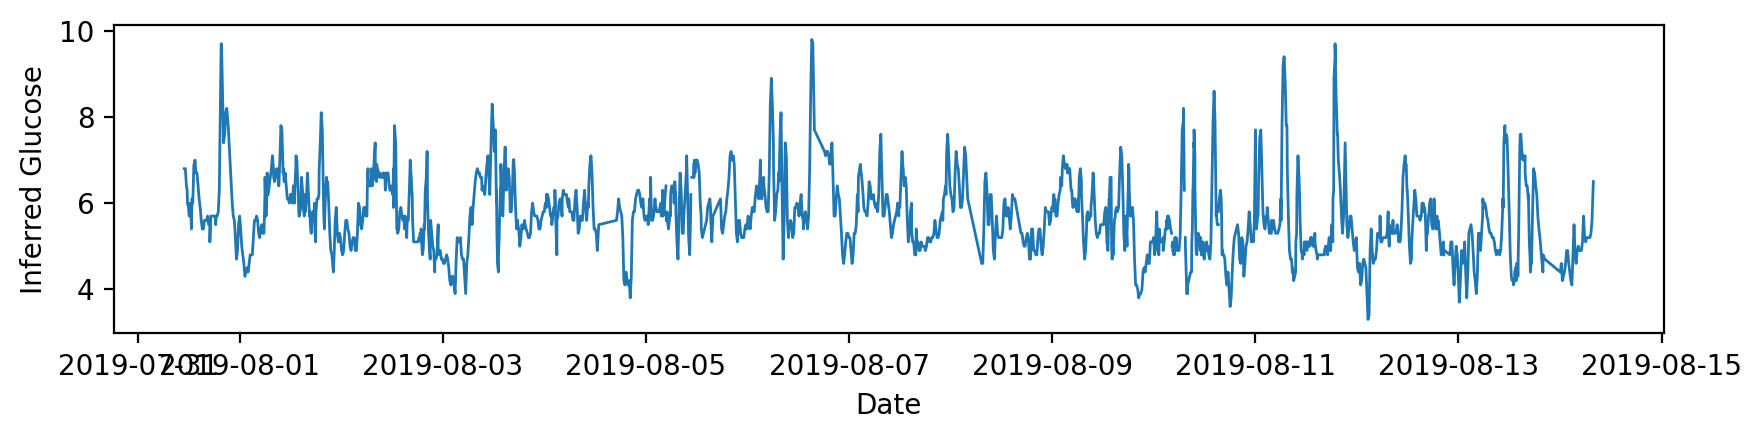

In [6]:
plt.figure(figsize=(10, 2))
plt.plot(df.Time, df.glucose, lw=1)
plt.xlabel("Date")
plt.ylabel("Inferred Glucose");

# Let's focus on one day

In [7]:
df_one_day = df[(df['Time']>='2019-08-04')&(df['Time']<'2019-08-05')].copy()

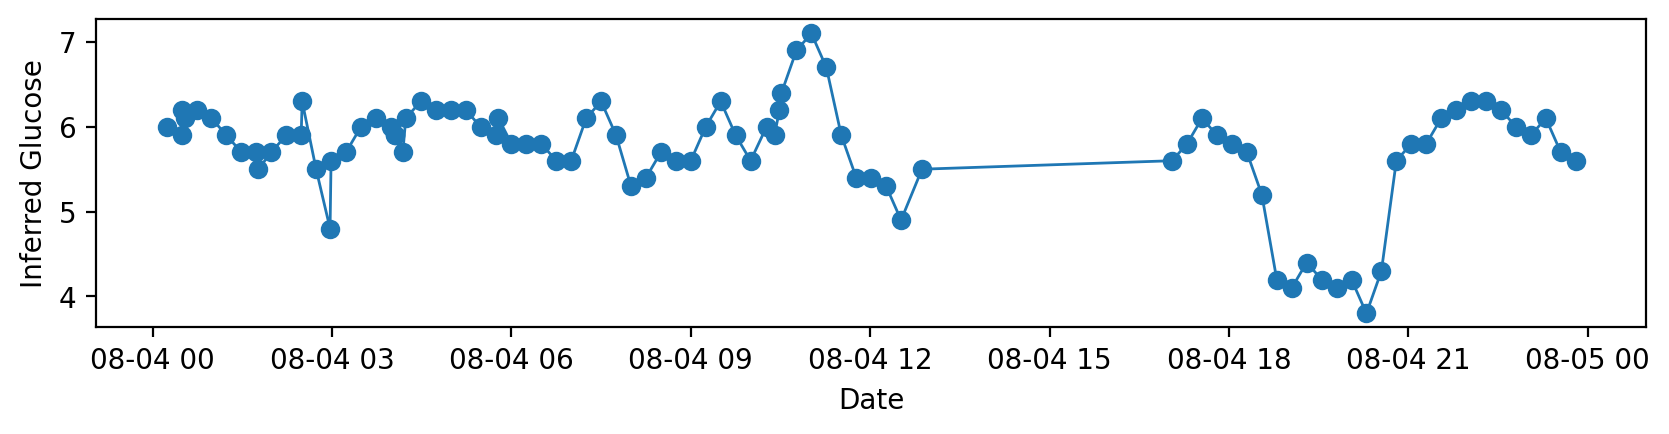

In [8]:
plt.figure(figsize=(10, 2))
plt.plot(df_one_day.Time, df_one_day.glucose, lw=1, marker="o")
plt.xlabel("Date")
plt.ylabel("Inferred Glucose");

To make our life easier, we gonna transform time into minute of the day:

In [9]:
df_one_day['minute'] = df_one_day.sort_values(by='Time')['Time'].apply(lambda t: t.hour*60+t.minute)

In [10]:
df_one_day.head()

,Time,glucose,minute
443,2019-08-04 00:14:00,6.0,14
444,2019-08-04 00:29:00,5.9,29
446,2019-08-04 00:29:00,6.2,29
445,2019-08-04 00:32:00,6.1,32
447,2019-08-04 00:44:00,6.2,44


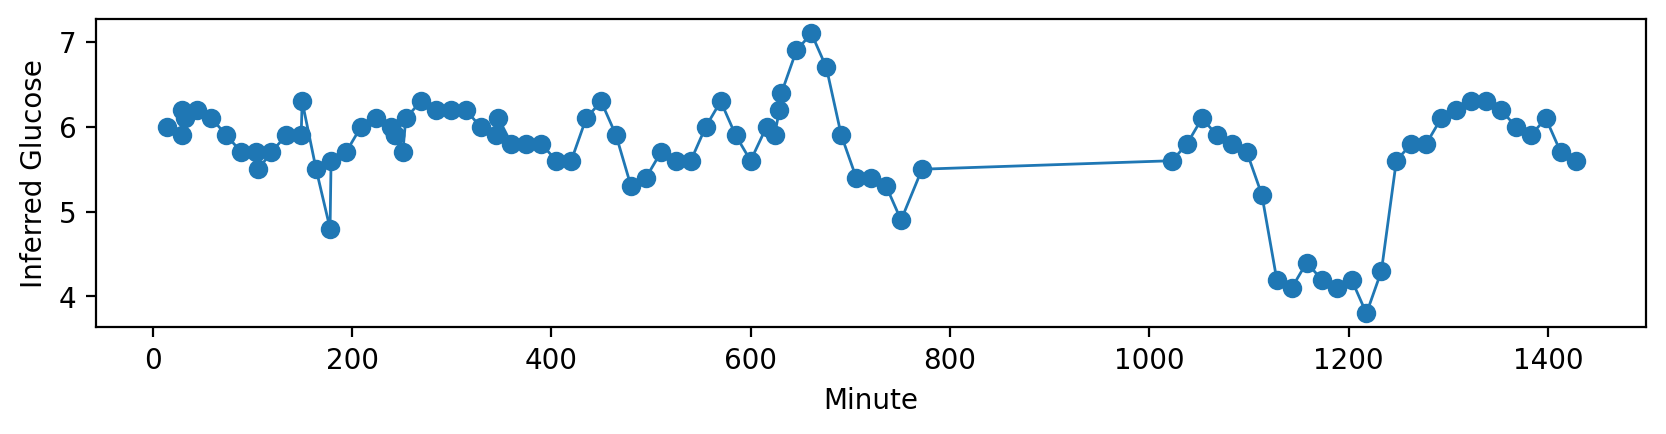

In [11]:
plt.figure(figsize=(10, 2))
plt.plot(df_one_day.minute, df_one_day.glucose, lw=1, marker="o")
plt.xlabel("Minute")
plt.ylabel("Inferred Glucose");

Note that there are missing values, but there are no `NaN` in our data frame!

In [12]:
df_one_day.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90 entries, 443 to 532
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Time     90 non-null     datetime64[ns]
 1   glucose  90 non-null     float64       
 2   minute   90 non-null     int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 2.8 KB


Let's change that. First, let's make time interval constant: every 15 minutes. 

We will average values within the same 15 minutes, and if we don't have any values within the 15 minutes, it is a missing value!

# Binning data

In [13]:
# Define bin edges from 0 to 60*24 (full day), or just your min to max + 15
start = 0
end = 60 * 24  # or df['Minute_of_Day'].max() + 15
bin_edges = np.arange(start, end + 15, 15)

In [14]:
bin_edges

array([   0,   15,   30,   45,   60,   75,   90,  105,  120,  135,  150,
        165,  180,  195,  210,  225,  240,  255,  270,  285,  300,  315,
        330,  345,  360,  375,  390,  405,  420,  435,  450,  465,  480,
        495,  510,  525,  540,  555,  570,  585,  600,  615,  630,  645,
        660,  675,  690,  705,  720,  735,  750,  765,  780,  795,  810,
        825,  840,  855,  870,  885,  900,  915,  930,  945,  960,  975,
        990, 1005, 1020, 1035, 1050, 1065, 1080, 1095, 1110, 1125, 1140,
       1155, 1170, 1185, 1200, 1215, 1230, 1245, 1260, 1275, 1290, 1305,
       1320, 1335, 1350, 1365, 1380, 1395, 1410, 1425, 1440])

Let's categorize the minutes into these bins: 

In [15]:
df_one_day['15min_bin'] = pd.cut(df_one_day['minute'], bins=bin_edges, right=False, labels=bin_edges[:-1])

In [16]:
df_one_day.head()

,Time,glucose,minute,15min_bin
443,2019-08-04 00:14:00,6.0,14,0
444,2019-08-04 00:29:00,5.9,29,15
446,2019-08-04 00:29:00,6.2,29,15
445,2019-08-04 00:32:00,6.1,32,30
447,2019-08-04 00:44:00,6.2,44,30


Now we have many values within the same bin, let's average them!

In [17]:
df_one_day_binned = df_one_day.groupby('15min_bin')['glucose'].mean().reset_index()

In [18]:
df_one_day_binned.head()

,15min_bin,glucose
0,0,6.00
1,15,6.05
2,30,6.15
3,45,6.10
4,60,5.90


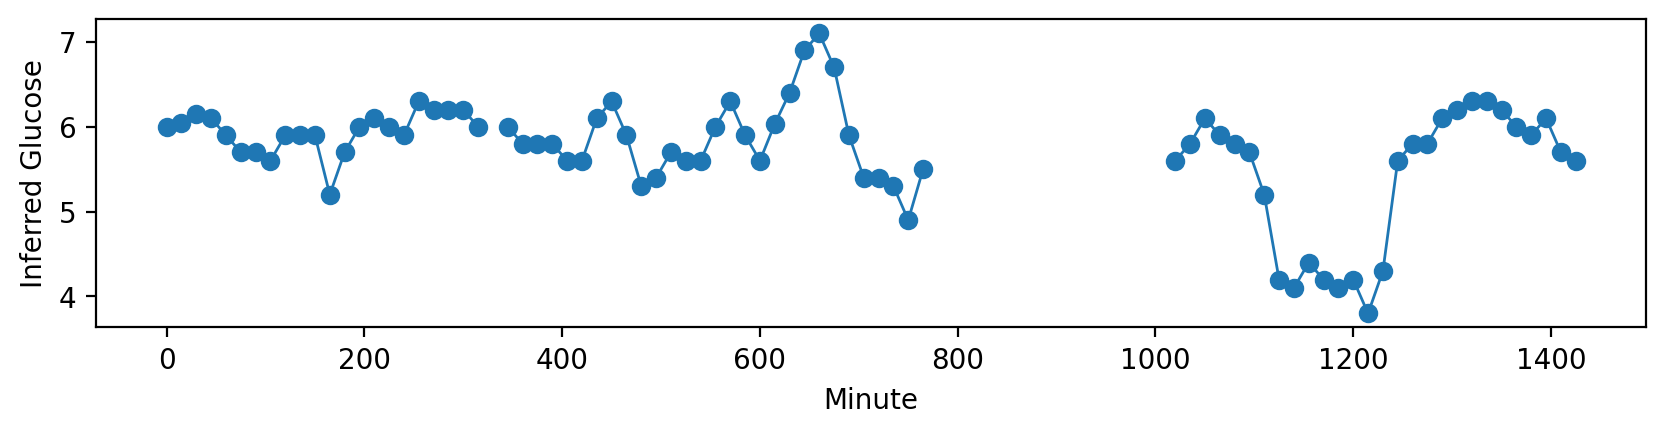

In [19]:
plt.figure(figsize=(10, 2))
plt.plot(df_one_day_binned["15min_bin"], df_one_day_binned.glucose, lw=1, marker="o")
plt.xlabel("Minute")
plt.ylabel("Inferred Glucose");

In [20]:
df_one_day_binned.to_csv("./data/binned_one_day.csv", index=False)

## Let's do the same for the whole data set 💪

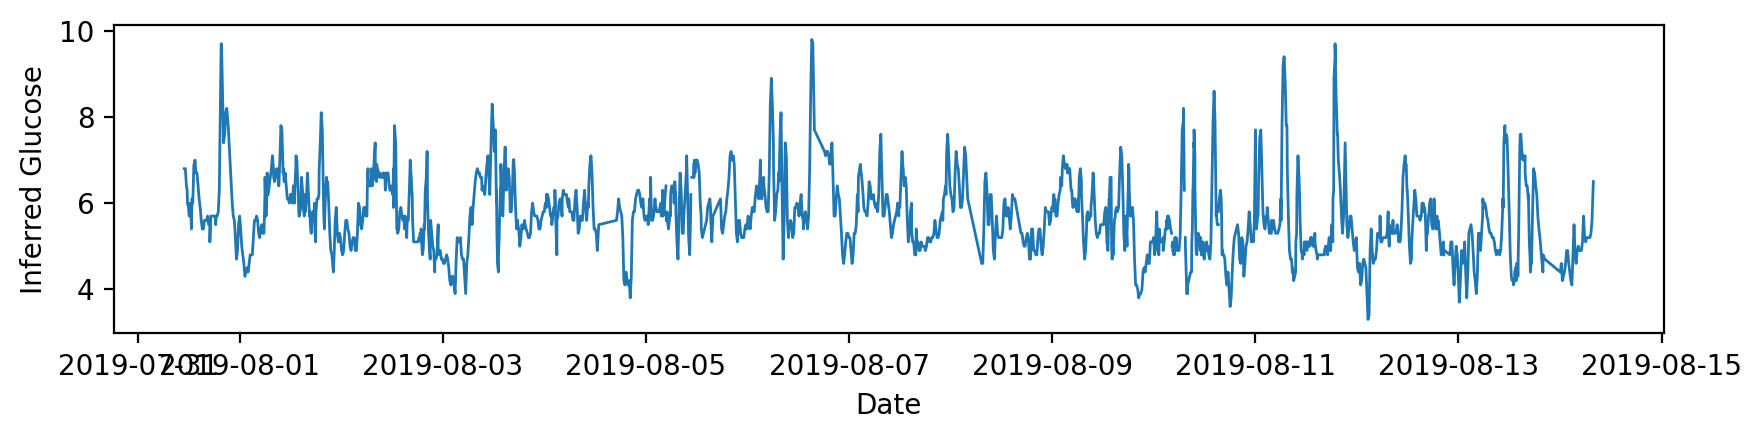

In [21]:
plt.figure(figsize=(10, 2))
plt.plot(df.Time, df.glucose, lw=1)
plt.xlabel("Date")
plt.ylabel("Inferred Glucose");

In [22]:
df.head()

,Time,glucose
0,2019-07-31 10:55:00,6.8
1,2019-07-31 11:10:00,6.8
3,2019-07-31 11:26:00,6.4
2,2019-07-31 11:36:00,6.3
4,2019-07-31 11:41:00,6.0


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1573 entries, 0 to 1572
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Time     1573 non-null   datetime64[ns]
 1   glucose  1564 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 36.9 KB


In [24]:
df[df.isna()["glucose"]]

,Time,glucose
407,2019-08-03 16:47:00,NaN
563,2019-08-05 04:45:00,NaN
597,2019-08-05 10:36:00,NaN
598,2019-08-05 10:36:00,NaN
602,2019-08-05 11:19:00,NaN
1081,2019-08-10 04:19:00,NaN
1101,2019-08-10 07:28:00,NaN
1153,2019-08-10 15:15:00,NaN
1424,2019-08-12 20:33:00,NaN


### It is time to bin into 15-minute time slices!

In [25]:
df_whole_binned = df.copy()

df_whole_binned['Time'] = pd.to_datetime(df['Time'])

df_whole_binned['15min_bin'] = df_whole_binned['Time'].dt.floor('15T')

In [26]:
df_whole_binned.head()

,Time,glucose,15min_bin
0,2019-07-31 10:55:00,6.8,2019-07-31 10:45:00
1,2019-07-31 11:10:00,6.8,2019-07-31 11:00:00
3,2019-07-31 11:26:00,6.4,2019-07-31 11:15:00
2,2019-07-31 11:36:00,6.3,2019-07-31 11:30:00
4,2019-07-31 11:41:00,6.0,2019-07-31 11:30:00


In [27]:
df_whole_binned = df_whole_binned.groupby('15min_bin')['glucose'].mean().reset_index()

In [28]:
df_whole_binned.head()

,15min_bin,glucose
0,2019-07-31 10:45:00,6.80
1,2019-07-31 11:00:00,6.80
2,2019-07-31 11:15:00,6.40
3,2019-07-31 11:30:00,6.15
4,2019-07-31 11:45:00,5.90


In [29]:
df_whole_binned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   15min_bin  1259 non-null   datetime64[ns]
 1   glucose    1259 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.8 KB


### It is time to impute NaNs 🥶

In [30]:
full_index = pd.date_range(
    start=df_whole_binned['15min_bin'].min(),
    end=df_whole_binned['15min_bin'].max(), freq='15T')

In [31]:
df_whole_binned = df_whole_binned.set_index('15min_bin').reindex(full_index).reset_index()
df_whole_binned.columns = ["15min_bin", "glucose"]

In [32]:
df_whole_binned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1333 entries, 0 to 1332
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   15min_bin  1333 non-null   datetime64[ns]
 1   glucose    1259 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 21.0 KB


In [33]:
df_whole_binned.head()

,15min_bin,glucose
0,2019-07-31 10:45:00,6.80
1,2019-07-31 11:00:00,6.80
2,2019-07-31 11:15:00,6.40
3,2019-07-31 11:30:00,6.15
4,2019-07-31 11:45:00,5.90


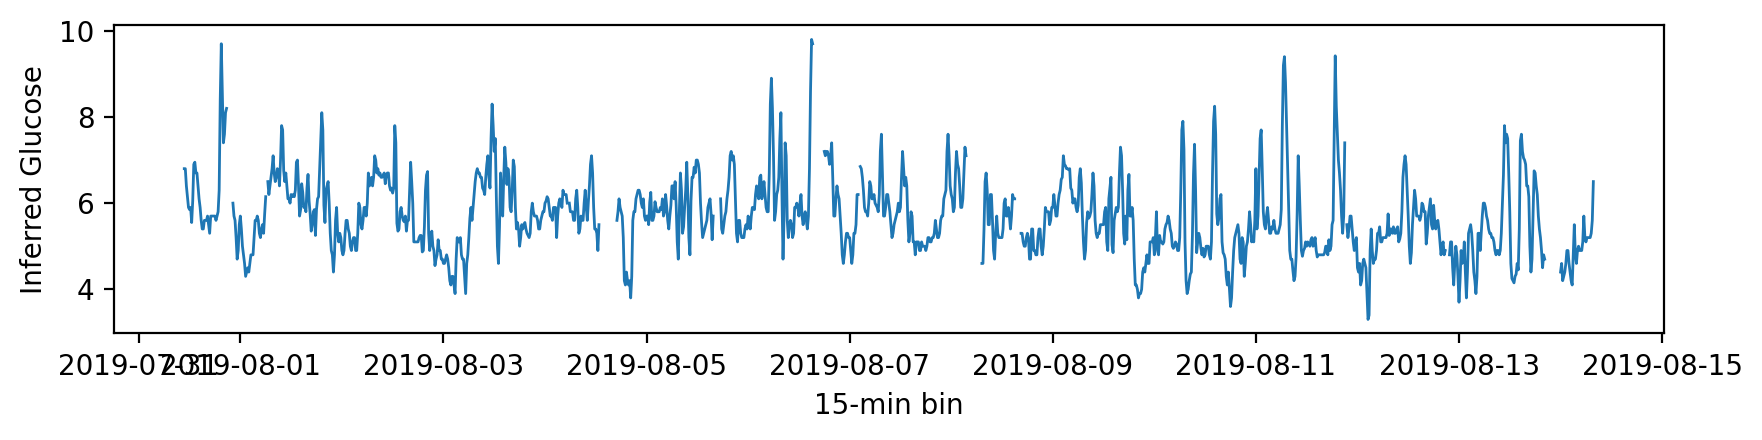

In [34]:
plt.figure(figsize=(10, 2))
plt.plot(df_whole_binned["15min_bin"], df_whole_binned.glucose, lw=1)
plt.xlabel("15-min bin")
plt.ylabel("Inferred Glucose");

In [35]:
df_whole_binned.to_csv("./data/binned_whole_data_set.csv", index=False)